In [1]:
import os, random, shutil, json, time
from pathlib import Path

import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from torchvision import models
import cv2
import albumentations as A
from albumentations.pytorch import ToTensorV2

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from tqdm import tqdm

# ========== 路径配置：修改为你的原始数据根目录 ==========
# 假设你的数据是：Root/Type_01_(Raw_Gesture)/A/A_1.jpg ... 到 Z/Z_1500.jpg
ROOT = Path(r"Root/grabcut_img")  # <-- 改这里（绝对路径）
DEST = ROOT.parent / "grabcut_split"  # 划分后的输出目录：与 Root 同级

# 类别 A-Z
CLASSES = [chr(i) for i in range(ord('A'), ord('Z')+1)]
NUM_CLASSES = len(CLASSES)

# 训练超参数
IMG_SIZE    = 224
BATCH_SIZE  = 64
EPOCHS      = 40
BASE_LR     = 1e-4
WEIGHT_DECAY= 3e-4
PATIENCE    = 10  # 早停耐心
SPLIT_RATIO = (0.8, 0.1, 0.1)  # train/val/test

# 设备
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# 随机种子
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if device.type == "cuda":
    torch.cuda.manual_seed_all(SEED)


Device: cuda


In [2]:
# # 创建划分目标目录
# for split in ['train','val','test']:
#     for c in CLASSES:
#         (DEST/split/c).mkdir(parents=True, exist_ok=True)

# # 随机划分并复制
# for c in CLASSES:
#     src_dir = ROOT / c
#     imgs = sorted([p for p in src_dir.glob("*.jpg")])
#     if not imgs:
#         raise FileNotFoundError(f"No images found in {src_dir}")
#     random.shuffle(imgs)
#     n = len(imgs)
#     n_train = int(n*SPLIT_RATIO[0])
#     n_val   = int(n*SPLIT_RATIO[1])
#     train_imgs = imgs[:n_train]
#     val_imgs   = imgs[n_train:n_train+n_val]
#     test_imgs  = imgs[n_train+n_val:]

#     for subset, lst in [('train', train_imgs), ('val', val_imgs), ('test', test_imgs)]:
#         dst_dir = DEST/subset/c
#         for p in lst:
#             dst = dst_dir/p.name
#             if not dst.exists():
#                 shutil.copy(p, dst)

# print("Data split finished at:", DEST)


In [2]:
# ===== HandDataset with HSV-V equalization + ImageNet normalize =====
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2
import numpy as np
from pathlib import Path

IMAGENET_MEAN = (0.485, 0.456, 0.406)
IMAGENET_STD  = (0.229, 0.224, 0.225)


def mixup_data(x, y, alpha=0.4):
    if alpha <= 0:
        return x, y, y, 1.0
    lam = np.random.beta(alpha, alpha)
    batch_size = x.size(0)
    index = torch.randperm(batch_size, device=x.device)
    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

def mixup_criterion(crit, pred, y_a, y_b, lam):
    return lam * crit(pred, y_a) + (1 - lam) * crit(pred, y_b)

def hsv_equalize_v(rgb_img: np.ndarray, **kwargs) -> np.ndarray:
    if rgb_img.dtype != np.uint8:
        rgb_img = np.clip(rgb_img, 0, 255).astype(np.uint8)
    hsv = cv2.cvtColor(rgb_img, cv2.COLOR_RGB2HSV)
    h, s, v = cv2.split(hsv)
    v_eq = cv2.equalizeHist(v)
    hsv_eq = cv2.merge([h, s, v_eq])
    rgb_eq = cv2.cvtColor(hsv_eq, cv2.COLOR_HSV2RGB)
    return rgb_eq


class HandDataset(Dataset):
    def __init__(self, root, classes, phase='train', size=224):
        self.paths = []
        self.labels = []
        self.class_to_idx = {c:i for i,c in enumerate(classes)}
        self.phase = phase
        self.size = size

        root = Path(root)
        for c in classes:
            # 若你的数据里可能有 png/jpeg，可改成多后缀扫描
            for p in root.joinpath(c).glob("*.jpg"):
                self.paths.append(str(p))
                self.labels.append(self.class_to_idx[c])

        # ---- Albumentations pipeline ----
        
        
        if phase == 'train':
            self.tf = A.Compose([
                # ① 亮度稳态预处理（保留）
                A.Lambda(image=hsv_equalize_v, name="HSV_V_Equalize"),

                # ② 随机裁剪+缩放到 size×size（替换掉原来的 A.Resize）
                A.RandomResizedCrop(height=size, width=size,
                                    scale=(0.8, 1.0), ratio=(0.9, 1.1), p=1.0),

                # ③ 轻几何扰动（保留/可微调，幅度略收敛避免与RRC叠加过强）
                A.Affine(scale=(0.9, 1.1), rotate=(-12, 12),
                        translate_percent=(0.0, 0.05), p=0.8),

                # ④ 光照与颜色（新增 + 原有）
                A.RandomBrightnessContrast(0.3, 0.3, p=0.4),  # 新增
                A.ColorJitter(0.25, 0.25, 0.25, 0.1, p=0.4),

                # ⑤ 模糊与遮挡（新增）
                A.MotionBlur(p=0.1),                           # 新增：运动模糊
                A.GaussianBlur(3, p=0.15),                     # 原有幅度稍降
                A.CoarseDropout(max_holes=3,
                                max_height=int(0.15*size),
                                max_width=int(0.15*size),
                                p=0.3),                        # 新增：轻遮挡

                # ⑥ 镜像（若左右有语义则改为 p=0 或移除）
                A.HorizontalFlip(p=0.5),

                # ⑦ 与ResNet18对齐的归一化 + 张量化（保持在最后）
                A.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
                ToTensorV2()
            ])
        else:
            self.tf = A.Compose([
                A.Lambda(image=hsv_equalize_v, name="HSV_V_Equalize"),
                A.Resize(size, size),  # 验证/测试仍用确定性Resize
                A.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
                ToTensorV2()
            ])

        
        
        
        # if phase == 'train':
        #     self.tf = A.Compose([
        #         # ① 先做 HSV 的 V 通道均衡（照度归一）
        #         A.Lambda(image=hsv_equalize_v, name="HSV_V_Equalize"),
        #         # ② 几何与颜色增广（与原来一致，幅度可按需微调）
        #         A.Resize(size, size),
        #         A.Affine(scale=(0.9,1.1), rotate=(-15,15), translate_percent=(0.0,0.05), p=0.8),
        #         A.ColorJitter(0.25,0.25,0.25,0.1, p=0.5),
        #         A.GaussianBlur(3, p=0.2),
        #         A.HorizontalFlip(p=0.5),
        #         # ③ 与 ResNet18 预训练对齐的 ImageNet 归一化
        #         A.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
        #         ToTensorV2()
        #     ])
        # else:
        #     self.tf = A.Compose([
        #         # 验证/测试也做照度均衡（不属于“增广”，属于稳态预处理）
        #         A.Lambda(image=hsv_equalize_v, name="HSV_V_Equalize"),
        #         A.Resize(size, size),
        #         A.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
        #         ToTensorV2()
        #     ])

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, i):
        p = self.paths[i]
        y = self.labels[i]
        img_bgr = cv2.imread(p)
        if img_bgr is None:
            raise RuntimeError(f"Failed to read image: {p}")
        img = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

        x = self.tf(image=img)['image']  # [3,H,W] float32 (normalized)
        return x, y

# ===== Rebuild datasets & dataloaders =====
train_ds = HandDataset(DEST/'train', CLASSES, 'train', IMG_SIZE)
val_ds   = HandDataset(DEST/'val',   CLASSES, 'val',   IMG_SIZE)
test_ds  = HandDataset(DEST/'test',  CLASSES, 'val',   IMG_SIZE)  # 无增广等同 'test'

# DataLoader：在 GPU 上建议 pin_memory=True；Windows 常用 num_workers=0 更稳
import torch
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,
                          num_workers=0, pin_memory=True, persistent_workers=False)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False,
                          num_workers=0, pin_memory=True, persistent_workers=False)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False,
                          num_workers=0, pin_memory=True, persistent_workers=False)

len(train_ds), len(val_ds), len(test_ds)


C:\Users\Michaelli\AppData\Local\Temp\ipykernel_27760\1777223452.py:61: DeprecationWarning: Initializing with 'height' and 'width' is deprecated. Please use a tuple (height, width) for the 'size' argument.
  A.RandomResizedCrop(height=size, width=size,
c:\Users\Michaelli\AppData\Local\Programs\Python\Python312\Lib\site-packages\albumentations\augmentations\blur\transforms.py:190: UserWarning: blur_limit and sigma_limit minimum value can not be both equal to 0. blur_limit minimum value changed to 3.
  warnings.warn(


(21660, 2698, 4559)

In [3]:
resnet18 = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

# 可选：先冻结部分层，稳定训练
for name, p in resnet18.named_parameters():
    if any(k in name for k in ["layer1","layer2"]):
        p.requires_grad = False

# 改最后全连接层输出 26 类
# resnet18.fc = nn.Linear(resnet18.fc.in_features, NUM_CLASSES)
# resnet18 = resnet18.to(device)

# 改最后全连接层：Dropout + Linear（降低过拟合）
in_features = resnet18.fc.in_features
resnet18.fc = nn.Sequential(
    nn.Dropout(p=0.5),                 # ← Dropout 50%
    nn.Linear(in_features, NUM_CLASSES)
)
resnet18 = resnet18.to(device)

# criterion = nn.CrossEntropyLoss()
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

optimizer = torch.optim.AdamW(filter(lambda p: p.requires_grad, resnet18.parameters()),
                              lr=BASE_LR, weight_decay=WEIGHT_DECAY)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="max", factor=0.5, patience=3)

scaler = torch.cuda.amp.GradScaler(enabled=(device.type=="cuda"))  # 混合精度


C:\Users\Michaelli\AppData\Local\Temp\ipykernel_27760\3824848778.py:27: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(device.type=="cuda"))  # 混合精度


In [5]:
best_val_acc = 0.0
best_state = None
history = {"train_loss": [], "val_acc": []}
no_improve_epochs = 0

print(f"Training on: {device}")
print("Model device:", next(resnet18.parameters()).device)

print(f"Training on: {device}, model device: {next(resnet18.parameters()).device}")

print("====== TRAINING START ======")
print(f"Global device setting: {device}")
print(f"Model currently on: {next(resnet18.parameters()).device}")

for epoch in range(1, EPOCHS + 1):
    # 确保模型在 GPU 上
    resnet18.train()
    model_device = next(resnet18.parameters()).device
    print(f"[Epoch {epoch}] model device -> {model_device}")

    running_loss = 0.0
    for x, y in tqdm(train_loader, desc=f"Epoch {epoch}/{EPOCHS}"):
        # ✅ 确认每批数据送到 GPU
        x = x.to(device, non_blocking=True)
        y = y.to(device, non_blocking=True, dtype=torch.long)

        optimizer.zero_grad(set_to_none=True)

        from torch import amp
        # with amp.autocast(device_type="cuda", enabled=(device.type == "cuda")):
        #     logits = resnet18(x)
        #     loss = criterion(logits, y)
        with amp.autocast(device_type="cuda", enabled=(device.type == "cuda")):
            x_mixed, y_a, y_b, lam = mixup_data(x, y, alpha=0.4)
            logits = resnet18(x_mixed)
            loss = mixup_criterion(criterion, logits, y_a, y_b, lam)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item() * x.size(0)



    train_loss = running_loss / len(train_ds)

    # 验证
    resnet18.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for x, y in val_loader:
            x = x.to(device, non_blocking=True)
            y = torch.tensor(y, dtype=torch.long, device=device)
            pred = resnet18(x).argmax(1)
            correct += (pred == y).sum().item()
            total += y.size(0)
    val_acc = correct / total

    scheduler.step(val_acc)
    history["train_loss"].append(train_loss)
    history["val_acc"].append(val_acc)

    print(f"[Epoch {epoch}] train_loss={train_loss:.4f}  val_acc={val_acc:.4f}")

    # 保存最佳
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_state = {k: v.cpu().clone() for k, v in resnet18.state_dict().items()}
        no_improve_epochs = 0
    else:
        no_improve_epochs += 1

    # 早停
    if no_improve_epochs >= PATIENCE:
        print("Early stopping triggered.")
        break

# 恢复最佳权重并保存
if best_state is not None:
    resnet18.load_state_dict(best_state)

SAVE_DIR = DEST.parent / "checkpoints"
SAVE_DIR.mkdir(exist_ok=True, parents=True)
model_path = SAVE_DIR / f"resnet18_gesture_model.pt"
torch.save(resnet18.state_dict(), model_path)
print("Best val acc:", best_val_acc, "saved to:", model_path)


Training on: cuda
Model device: cuda:0
Training on: cuda, model device: cuda:0
====== TRAINING START ======
Global device setting: cuda
Model currently on: cuda:0
[Epoch 1] model device -> cuda:0


Epoch 1/40: 100%|██████████| 339/339 [03:51<00:00,  1.46it/s]
C:\Users\Michaelli\AppData\Local\Temp\ipykernel_14956\1882981567.py:54: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype=torch.long, device=device)


[Epoch 1] train_loss=1.9074  val_acc=0.9681
[Epoch 2] model device -> cuda:0


Epoch 2/40: 100%|██████████| 339/339 [01:32<00:00,  3.68it/s]


[Epoch 2] train_loss=1.4698  val_acc=0.9926
[Epoch 3] model device -> cuda:0


Epoch 3/40: 100%|██████████| 339/339 [01:31<00:00,  3.71it/s]


[Epoch 3] train_loss=1.3757  val_acc=0.9937
[Epoch 4] model device -> cuda:0


Epoch 4/40: 100%|██████████| 339/339 [01:32<00:00,  3.68it/s]


[Epoch 4] train_loss=1.3000  val_acc=0.9974
[Epoch 5] model device -> cuda:0


Epoch 5/40: 100%|██████████| 339/339 [01:31<00:00,  3.69it/s]


[Epoch 5] train_loss=1.2994  val_acc=0.9974
[Epoch 6] model device -> cuda:0


Epoch 6/40: 100%|██████████| 339/339 [01:31<00:00,  3.69it/s]


[Epoch 6] train_loss=1.3110  val_acc=0.9985
[Epoch 7] model device -> cuda:0


Epoch 7/40: 100%|██████████| 339/339 [01:31<00:00,  3.69it/s]


[Epoch 7] train_loss=1.2458  val_acc=0.9981
[Epoch 8] model device -> cuda:0


Epoch 8/40: 100%|██████████| 339/339 [01:32<00:00,  3.68it/s]


[Epoch 8] train_loss=1.2315  val_acc=0.9989
[Epoch 9] model device -> cuda:0


Epoch 9/40: 100%|██████████| 339/339 [01:32<00:00,  3.65it/s]


[Epoch 9] train_loss=1.2028  val_acc=0.9989
[Epoch 10] model device -> cuda:0


Epoch 10/40: 100%|██████████| 339/339 [01:31<00:00,  3.70it/s]


[Epoch 10] train_loss=1.2048  val_acc=0.9993
[Epoch 11] model device -> cuda:0


Epoch 11/40: 100%|██████████| 339/339 [01:32<00:00,  3.66it/s]


[Epoch 11] train_loss=1.2114  val_acc=0.9989
[Epoch 12] model device -> cuda:0


Epoch 12/40: 100%|██████████| 339/339 [01:31<00:00,  3.70it/s]


[Epoch 12] train_loss=1.2286  val_acc=0.9996
[Epoch 13] model device -> cuda:0


Epoch 13/40: 100%|██████████| 339/339 [01:31<00:00,  3.70it/s]


[Epoch 13] train_loss=1.2113  val_acc=1.0000
[Epoch 14] model device -> cuda:0


Epoch 14/40: 100%|██████████| 339/339 [01:32<00:00,  3.68it/s]


[Epoch 14] train_loss=1.1944  val_acc=0.9989
[Epoch 15] model device -> cuda:0


Epoch 15/40: 100%|██████████| 339/339 [01:31<00:00,  3.71it/s]


[Epoch 15] train_loss=1.1545  val_acc=0.9996
[Epoch 16] model device -> cuda:0


Epoch 16/40: 100%|██████████| 339/339 [01:31<00:00,  3.69it/s]


[Epoch 16] train_loss=1.1756  val_acc=0.9993
[Epoch 17] model device -> cuda:0


Epoch 17/40: 100%|██████████| 339/339 [01:32<00:00,  3.68it/s]


[Epoch 17] train_loss=1.1610  val_acc=0.9993
[Epoch 18] model device -> cuda:0


Epoch 18/40: 100%|██████████| 339/339 [01:31<00:00,  3.70it/s]


[Epoch 18] train_loss=1.1499  val_acc=0.9993
[Epoch 19] model device -> cuda:0


Epoch 19/40: 100%|██████████| 339/339 [01:31<00:00,  3.70it/s]


[Epoch 19] train_loss=1.1479  val_acc=0.9993
[Epoch 20] model device -> cuda:0


Epoch 20/40: 100%|██████████| 339/339 [01:31<00:00,  3.70it/s]


[Epoch 20] train_loss=1.1142  val_acc=1.0000
[Epoch 21] model device -> cuda:0


Epoch 21/40: 100%|██████████| 339/339 [01:32<00:00,  3.68it/s]


[Epoch 21] train_loss=1.1479  val_acc=0.9993
[Epoch 22] model device -> cuda:0


Epoch 22/40: 100%|██████████| 339/339 [01:31<00:00,  3.71it/s]


[Epoch 22] train_loss=1.1514  val_acc=1.0000
[Epoch 23] model device -> cuda:0


Epoch 23/40: 100%|██████████| 339/339 [01:31<00:00,  3.71it/s]


[Epoch 23] train_loss=1.1332  val_acc=0.9993
Early stopping triggered.
Best val acc: 1.0 saved to: Root\checkpoints\resnet18_gesture_model.pt


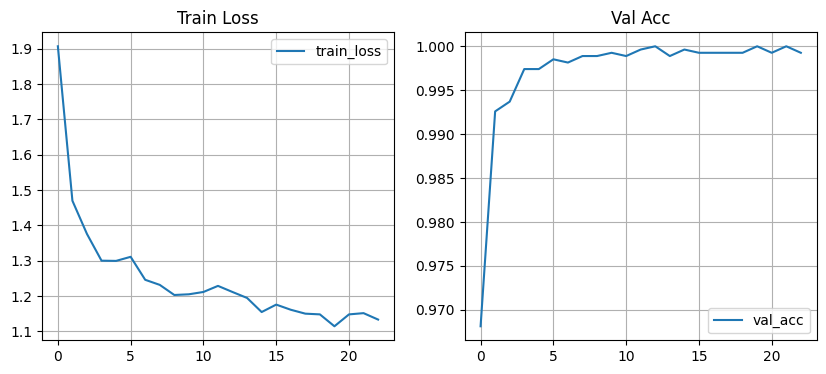

In [6]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history["train_loss"], label="train_loss")
plt.title("Train Loss")
plt.grid(True); plt.legend()

plt.subplot(1,2,2)
plt.plot(history["val_acc"], label="val_acc")
plt.title("Val Acc")
plt.grid(True); plt.legend()
plt.show()


C:\Users\Michaelli\AppData\Local\Temp\ipykernel_27760\4260448231.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  resnet18.load_state_dict(torch.load(model_path, map_loca

              precision    recall  f1-score   support

           A     0.7167    0.2009    0.3139       214
           B     0.8571    0.6540    0.7419       211
           C     0.3172    0.3151    0.3162       146
           D     0.1138    0.4726    0.1834       201
           E     0.9533    0.5152    0.6689       198
           F     0.1509    0.1203    0.1339       133
           G     0.1500    0.1084    0.1259       166
           H     0.8226    0.9745    0.8921       157
           I     0.2500    0.0955    0.1382       157
           J     0.7417    0.5057    0.6014       176
           K     0.9310    0.4197    0.5786       193
           L     0.4126    0.9867    0.5819       225
           M     0.0000    0.0000    0.0000       174
           N     0.0000    0.0000    0.0000       150
           O     0.5889    0.2994    0.3970       177
           P     0.3034    0.9281    0.4573       153
           Q     0.3846    0.1550    0.2210       129
           R     0.4901    

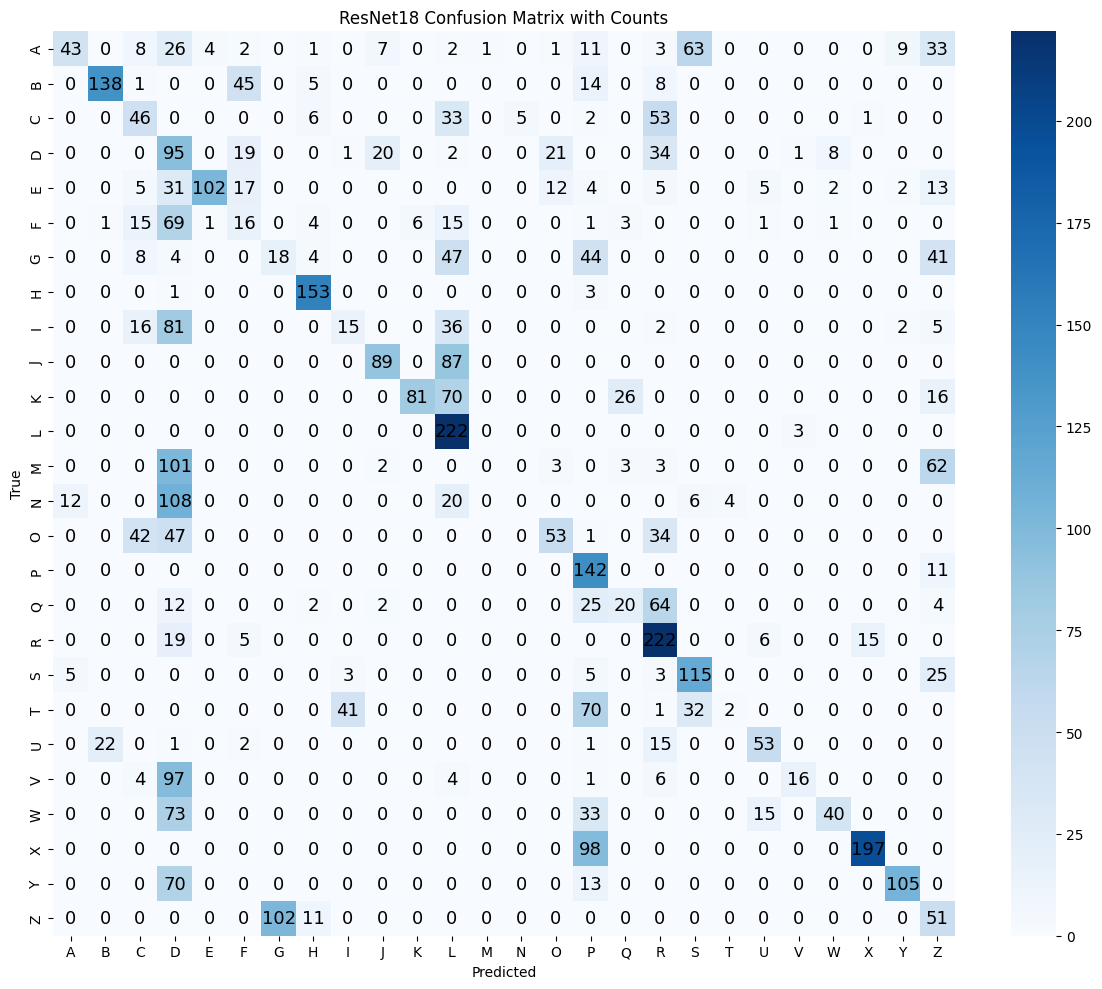

In [4]:
# 加载最佳权重（保险起见）
model_path = r"D:/Files/2025_Y4_S2/AMME5710/Major/root/resnet18_gesture_model.pt"
resnet18.load_state_dict(torch.load(model_path, map_location=device))

resnet18.eval()

ys, ps = [], []
with torch.no_grad():
    for x, y in tqdm(test_loader, desc="Testing"):
        x = x.to(device, non_blocking=True)
        pred = resnet18(x).argmax(1).cpu().numpy().tolist()
        ys.extend(y)
        ps.extend(pred)

print(classification_report(ys, ps, target_names=CLASSES, digits=4))

cm = confusion_matrix(ys, ps, labels=list(range(NUM_CLASSES)))

plt.figure(figsize=(12,10))
sns.heatmap(
    cm,
    annot=True,          # ✅ 在格子上显示数字
    fmt="d",             # ✅ 以整数显示（默认会是浮点数）
    cmap="Blues",        # 蓝色配色
    xticklabels=CLASSES, # 横轴标签：预测类别
    yticklabels=CLASSES, # 纵轴标签：真实类别
    cbar=True,           # 是否显示右侧颜色条，可设为 False
    annot_kws={"size": 13, "color": "black"}  # 数字样式
)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("ResNet18 Confusion Matrix with Counts")
plt.tight_layout()
plt.show()



Sample: Root\grabcut_split\test\B\B_450.jpg


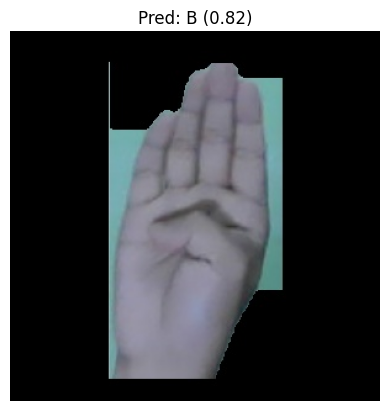

In [8]:
# 随机取一张测试图做推理
import random
sample_paths = list((DEST/'test').rglob("*.jpg"))
test_img_path = str(random.choice(sample_paths))
print("Sample:", test_img_path)

# 预处理与推理
img = cv2.cvtColor(cv2.imread(test_img_path), cv2.COLOR_BGR2RGB)
tf = A.Compose([A.Resize(IMG_SIZE, IMG_SIZE), A.Normalize(), ToTensorV2()])
x = tf(image=img)['image'].unsqueeze(0).to(device)

resnet18.eval()
with torch.no_grad():
    logits = resnet18(x)
    prob = torch.softmax(logits, dim=1)[0].cpu().numpy()
    pred_id = int(np.argmax(prob))
    pred_cls = CLASSES[pred_id]
    conf = float(np.max(prob))

plt.imshow(img); plt.axis('off')
plt.title(f"Pred: {pred_cls} ({conf:.2f})")
plt.show()
